In [1]:
import firebase_admin
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from firebase_admin import credentials, firestore
import os
import re
from scipy.spatial.transform import Rotation as R

cred = credentials.Certificate("adminkey.json")
firebase_admin.initialize_app(cred)
db = firestore.client()

In [58]:
ACTIVITIES = ["walk", "run"]
POSITIONS = ["dom_hand"]
SAMPLING_RATE = 100

In [32]:
def recording_to_dataframe(record):
    rows = []
    samples = record.get("samples", [])
    for sample in samples:
        accel = sample.get("accelerometer", {})
        gyro = sample.get("gyroscope", {})
        rot = sample.get("rotation", {})
        rows.append({
            "time": sample.get("timestamp"),

            "ax": accel.get("x"),
            "ay": accel.get("y"),
            "az": accel.get("z"),

            "gx": gyro.get("x"),
            "gy": gyro.get("y"),
            "gz": gyro.get("z"),

            "rw": rot.get("w"),
            "rx": rot.get("x"),
            "ry": rot.get("y"),
            "rz": rot.get("z"),
        })
    return (
        pd.DataFrame(rows)
        .sort_values("time")
        .reset_index(drop=True)
    )

In [47]:
def apply_global_frame(df):
    df_out = df.copy()
    q = df[["rw", "rx", "ry", "rz"]].to_numpy()
    q_scipy = np.column_stack([q[:, 1], q[:, 2], q[:, 3], q[:, 0]])
    q_scipy /= (np.linalg.norm(q_scipy, axis=1, keepdims=True) + 1e-9)
    rot = R.from_quat(q_scipy)
    gyro_local = np.zeros((len(df), 3))
    gyro_local[:, 0] = df["gy"].values
    gyro_local[:, 1] = df["gz"].values
    gyro_local[:, 2] = df["gx"].values
    acc_local = df[["ax", "ay", "az"]].to_numpy()
    acc_world = rot.apply(acc_local)
    gyro_world = rot.apply(gyro_local)
    df_out["ax_g"] = acc_world[:, 0]
    df_out["ay_g"] = acc_world[:, 1]
    df_out["az_g"] = acc_world[:, 2] - 9.81 

    df_out["gx_g"], df_out["gy_g"], df_out["gz_g"] = gyro_world.T

    return df_out

In [48]:
def fetch_data():
    processed_recordings = []

    for activity in ACTIVITIES:
        activity_ref = db.collection(activity)

        for position in POSITIONS:
            pos_doc = activity_ref.document(position)
            recordings_ref = pos_doc.collection("recordings")

            for rec_doc in recordings_ref.stream():
                record = rec_doc.to_dict()
                recording_id = rec_doc.id

                df = recording_to_dataframe(record)

                df_gft = apply_global_frame(df)

                df_gft["activity"] = activity
                df_gft["phone_position"] = position
                df_gft["recording_id"] = recording_id

                processed_recordings.append(df_gft)

                print(f"Processed recording {recording_id} ({len(df_gft)} samples)")

    print(f"Total recordings processed: {len(processed_recordings)}")
    return processed_recordings

In [59]:
gft_data = fetch_data()

Processed recording 2026-01-11T21:14:29.188Z (2983 samples)
Processed recording 2026-01-11T21:15:09.556Z (2982 samples)
Processed recording 2026-01-11T21:15:50.279Z (2982 samples)
Processed recording 2026-01-11T21:17:02.187Z (2982 samples)
Processed recording 2026-01-11T21:17:43.990Z (2981 samples)
Processed recording 2026-01-11T21:47:21.293Z (2983 samples)
Processed recording 2026-01-11T21:48:03.878Z (2983 samples)
Processed recording 2026-01-11T21:48:46.870Z (2982 samples)
Processed recording 2026-01-11T21:49:27.621Z (2985 samples)
Processed recording 2026-01-11T21:50:11.107Z (2983 samples)
Total recordings processed: 10


In [50]:
print(gft_data[0].head())

   time        ax        ay        az        gx         gy         gz  \
0   159 -4.010437 -5.655254 -6.038027  2.481680 -37.218630   8.177154   
1   178 -3.978714 -5.611410 -6.040121  2.350073 -38.897340   9.671966   
2   179 -3.979163 -5.611559 -6.004358  2.577977 -41.321309  10.622503   
3   188 -3.933374 -5.603329 -5.929240  3.010442 -43.177679  10.968695   
4   198 -3.902399 -5.619491 -5.799654  4.480855 -43.621208  10.060018   

         rw        rx        ry        rz      ax_g      ay_g      az_g  \
0  0.824844 -0.356239  0.194033  0.393800  1.752495 -8.987991 -8.992660   
1  0.822995 -0.359609  0.192750  0.395232  1.788970 -8.939279 -8.979318   
2  0.820979 -0.363206  0.191410  0.396784  1.845083 -8.896097 -8.898522   
3  0.818819 -0.367003  0.189960  0.398446  1.926506 -8.793995 -8.820634   
4  0.816577 -0.370919  0.188342  0.400185  2.020060 -8.666051 -8.686479   

        gx_g       gy_g       gz_g activity phone_position  \
0 -29.217168 -13.630488  20.465039     walk     

In [51]:
def sanitize_filename(name: str) -> str:
    return re.sub(r'[<>:"/\\|?*]', '_', name)

def save_gft_recordings(gft_data, base_dir="data"):
    for df in gft_data:
        activity = df["activity"].iloc[0]
        position = df["phone_position"].iloc[0]
        recording_id = df["recording_id"].iloc[0]
        safe_recording_id = sanitize_filename(recording_id)
        dir_path = os.path.join(base_dir, activity, position)
        os.makedirs(dir_path, exist_ok=True)
        file_path = os.path.join(dir_path, f"{safe_recording_id}.csv")
        df.to_csv(file_path, index=False)
        print(f"Saved: {file_path}")

In [52]:
save_gft_recordings(gft_data, base_dir="data")

Saved: data\walk\dom_hand\2026-01-11T21_14_29.188Z.csv
Saved: data\walk\dom_hand\2026-01-11T21_15_09.556Z.csv
Saved: data\walk\dom_hand\2026-01-11T21_15_50.279Z.csv
Saved: data\walk\dom_hand\2026-01-11T21_17_02.187Z.csv
Saved: data\walk\dom_hand\2026-01-11T21_17_43.990Z.csv
Saved: data\walk\nondom_hand\2026-01-11T21_18_55.760Z.csv
Saved: data\walk\nondom_hand\2026-01-11T21_19_41.281Z.csv
Saved: data\walk\nondom_hand\2026-01-11T21_20_26.603Z.csv
Saved: data\walk\nondom_hand\2026-01-11T21_21_08.741Z.csv
Saved: data\walk\nondom_hand\2026-01-11T21_21_57.567Z.csv
Saved: data\walk\dom_pocket\2026-01-11T21_24_53.142Z.csv
Saved: data\walk\dom_pocket\2026-01-11T21_25_42.164Z.csv
Saved: data\walk\dom_pocket\2026-01-11T21_26_53.868Z.csv
Saved: data\walk\dom_pocket\2026-01-11T21_27_53.379Z.csv
Saved: data\walk\dom_pocket\2026-01-11T21_46_28.754Z.csv
Saved: data\walk\nondom_pocket\2026-01-11T21_29_10.561Z.csv
Saved: data\walk\nondom_pocket\2026-01-11T21_30_00.717Z.csv
Saved: data\walk\nondom_pocket

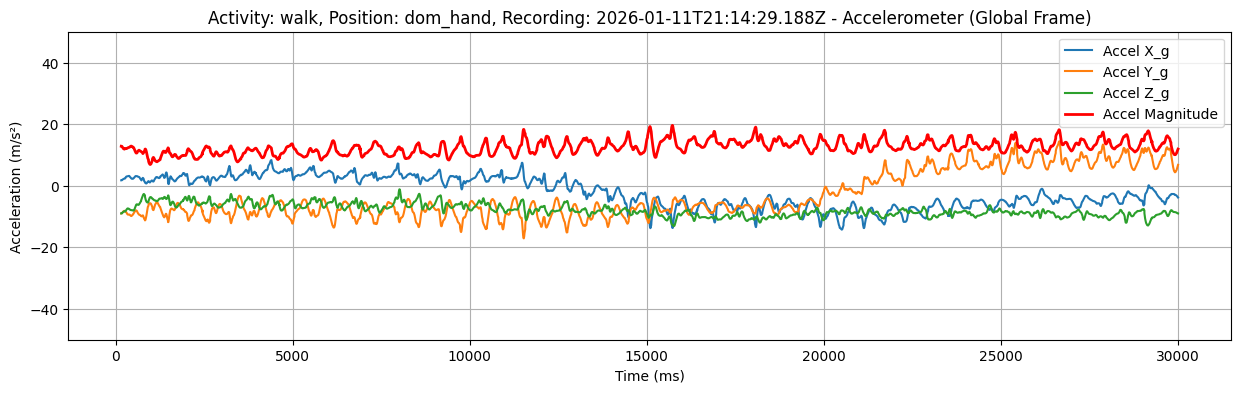

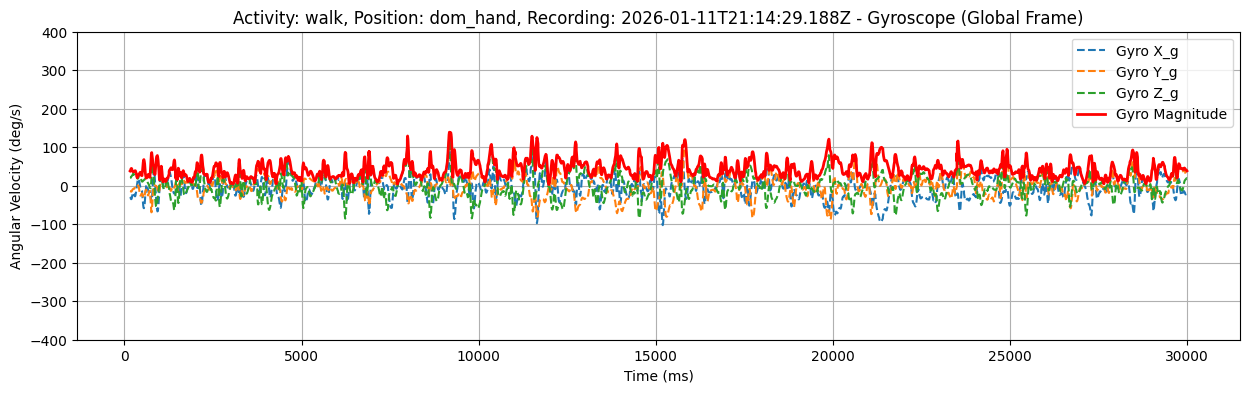

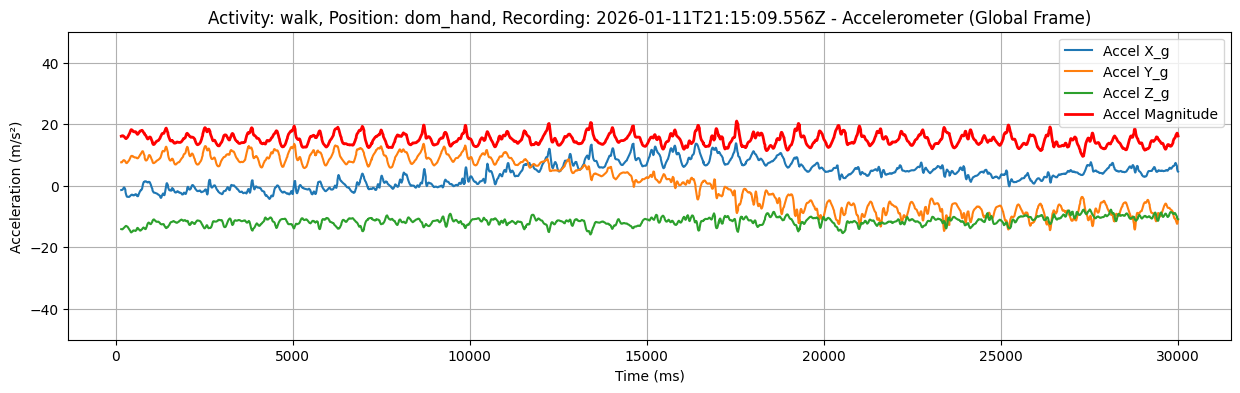

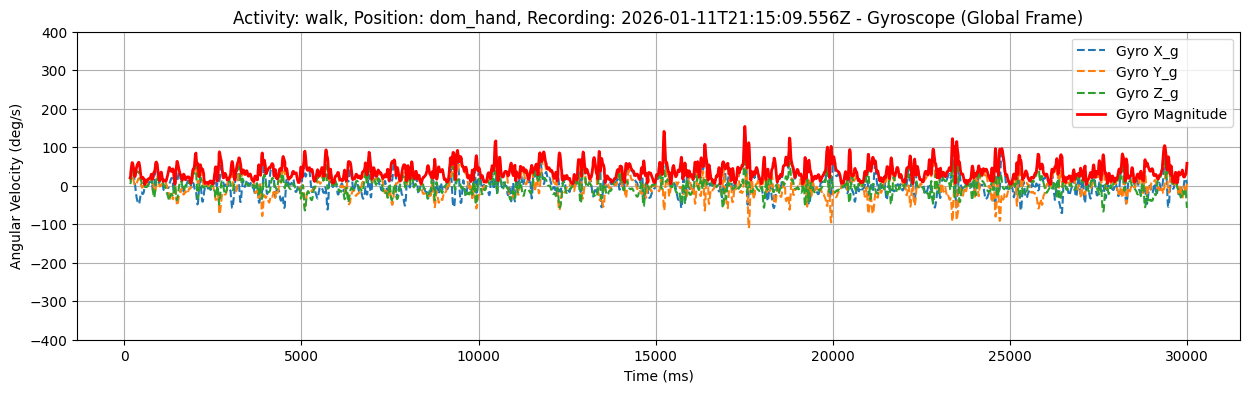

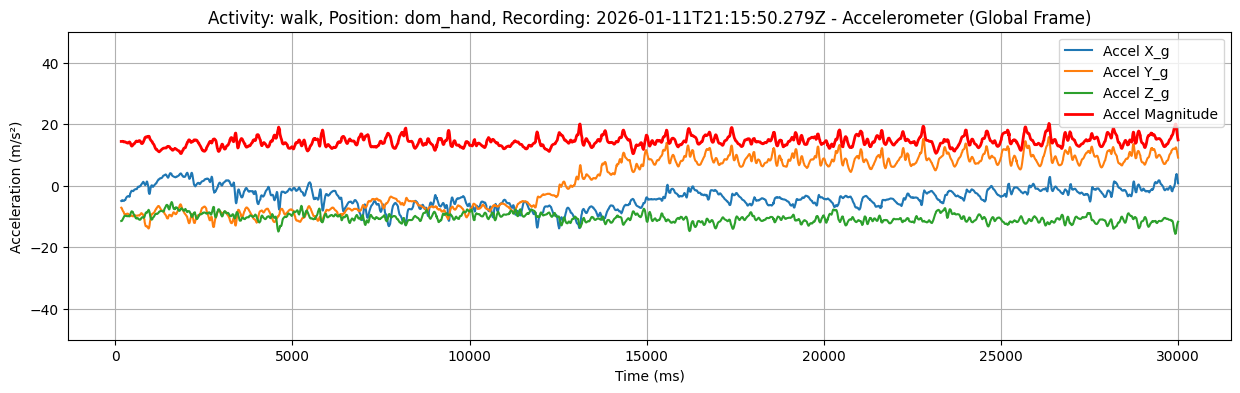

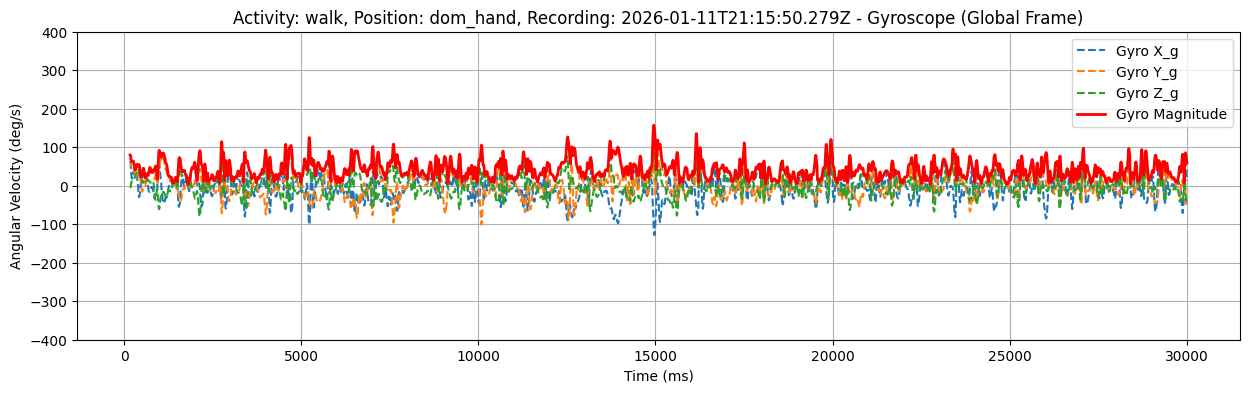

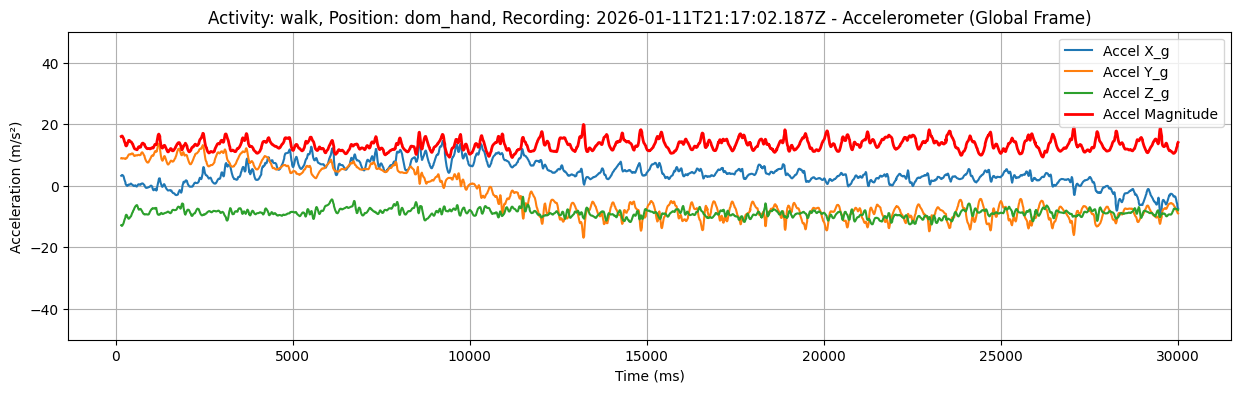

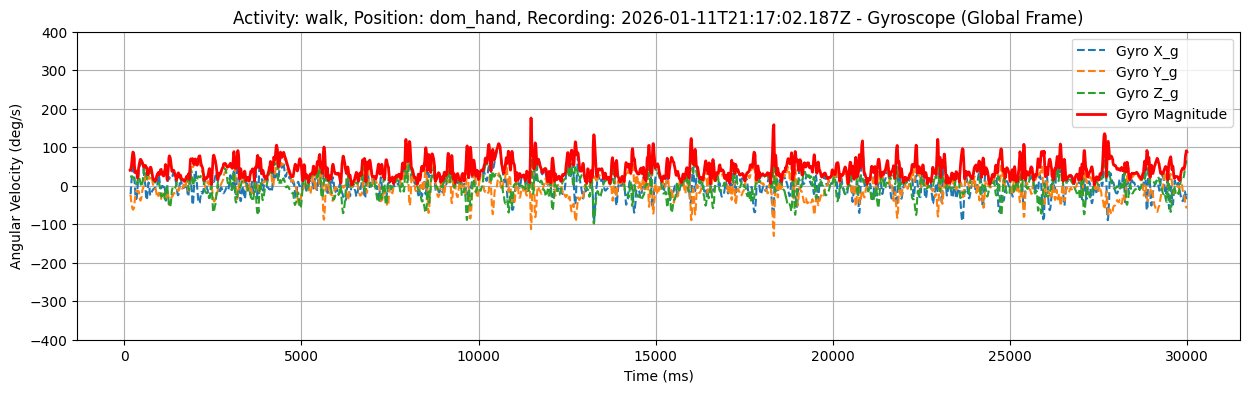

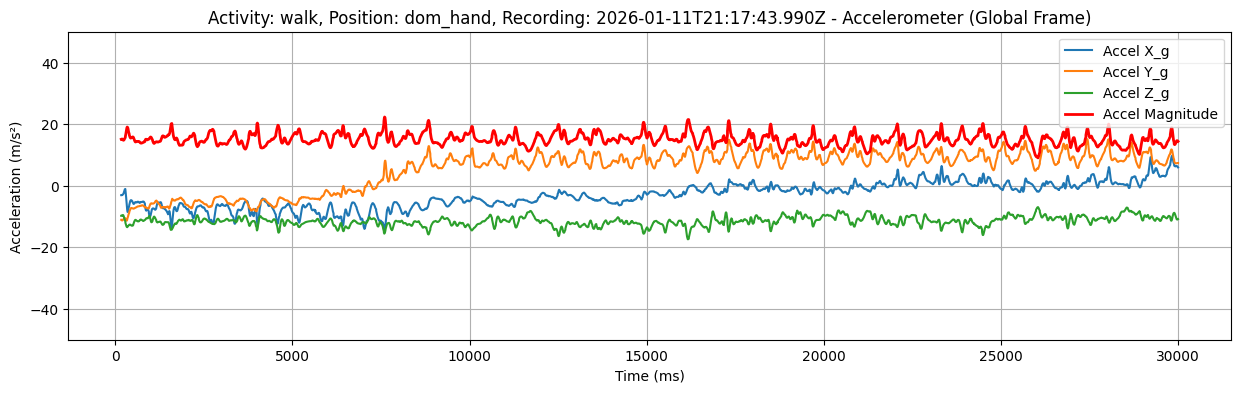

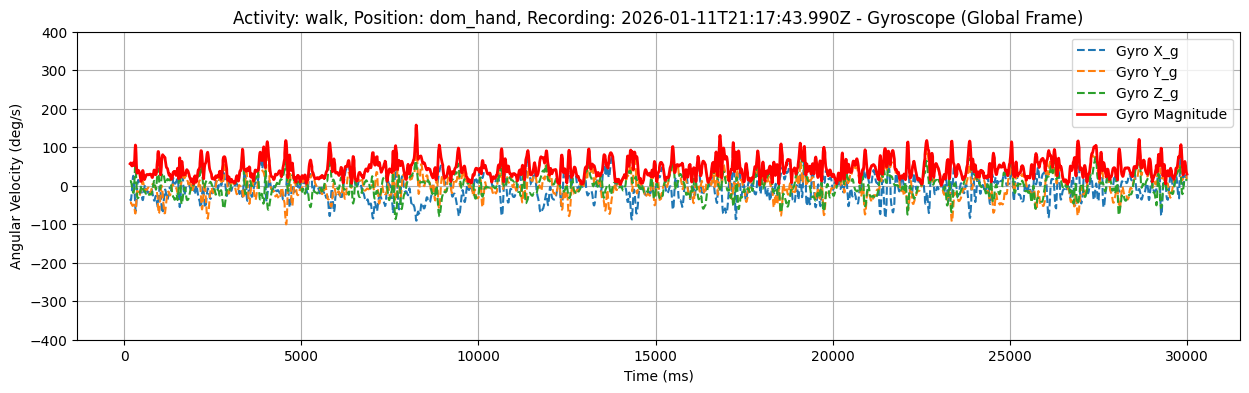

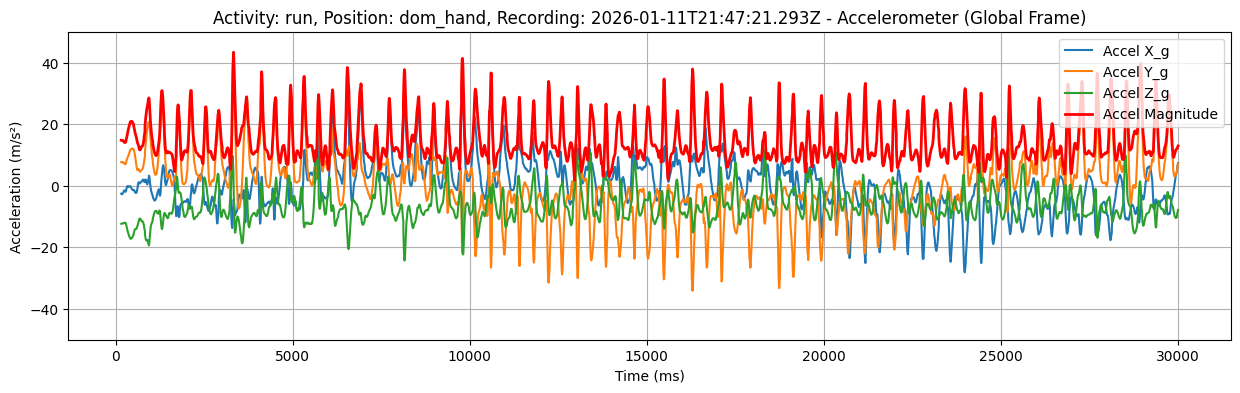

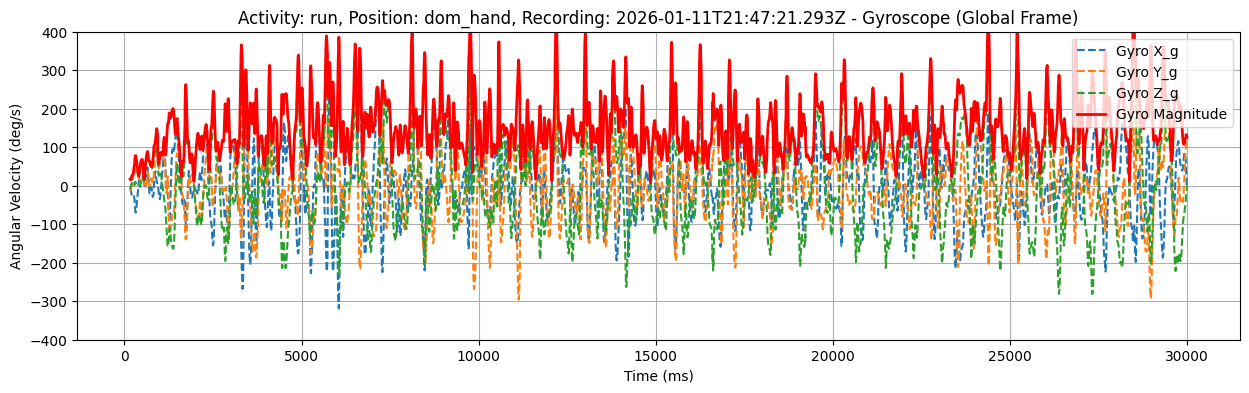

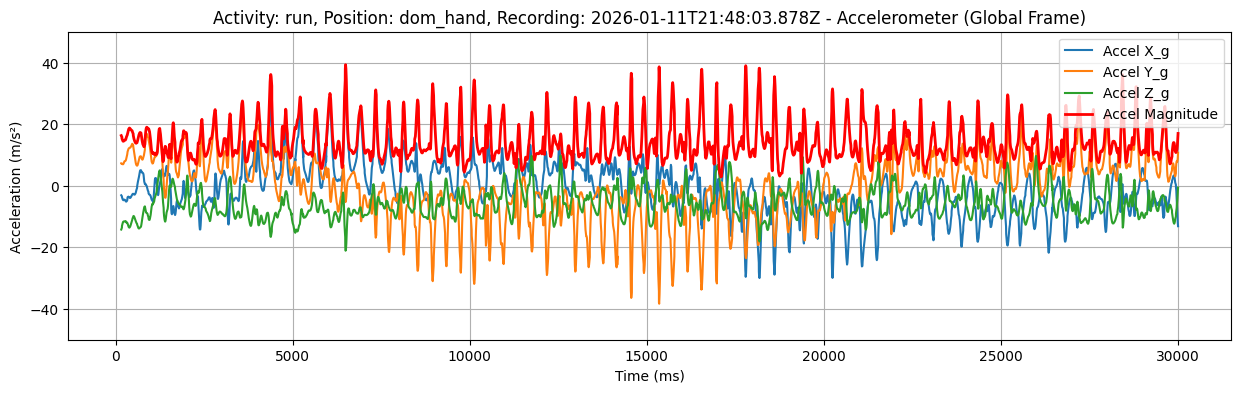

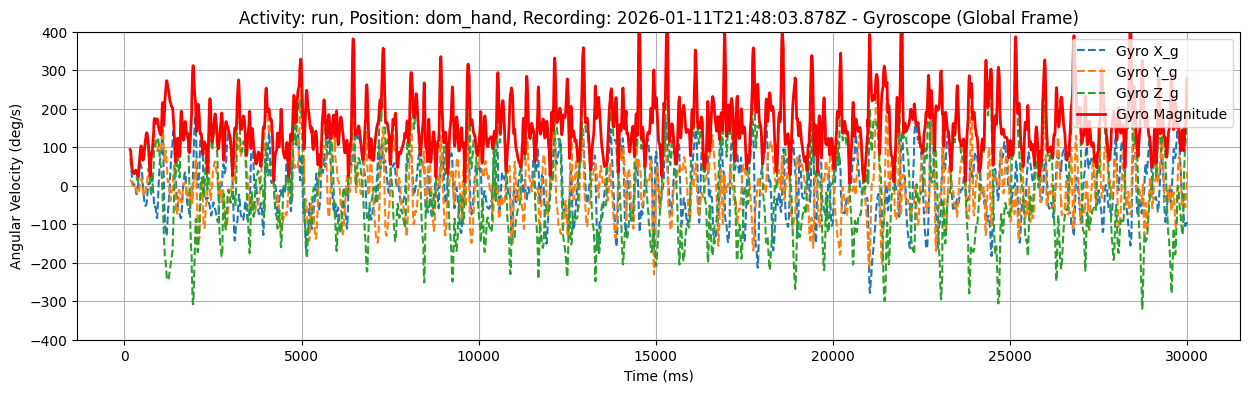

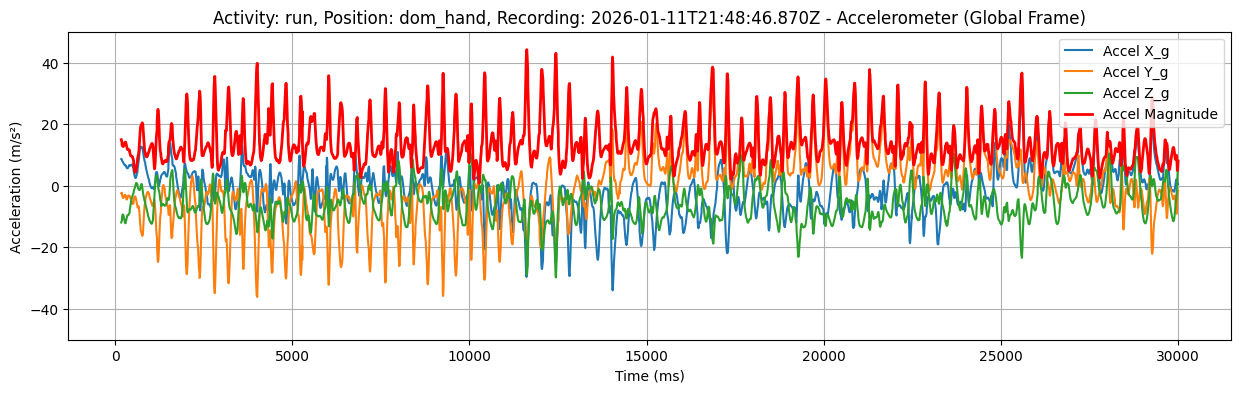

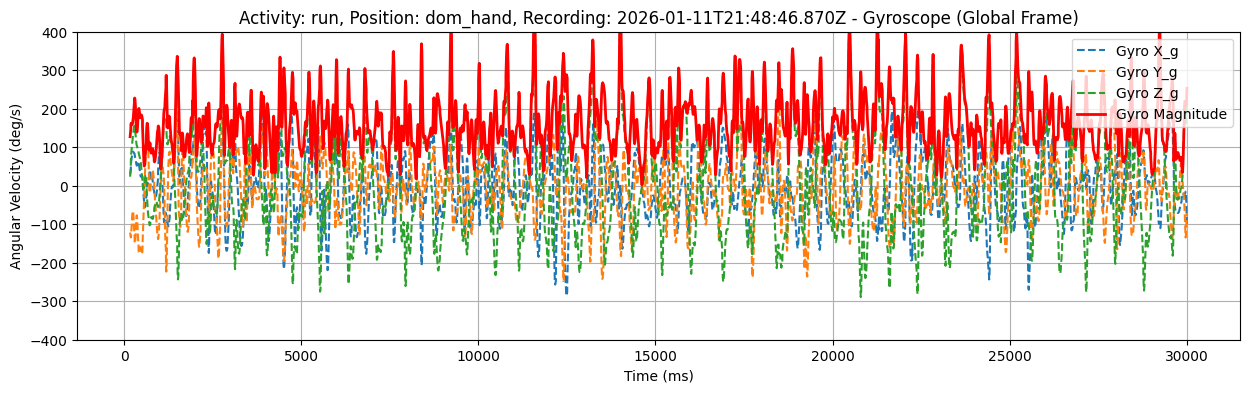

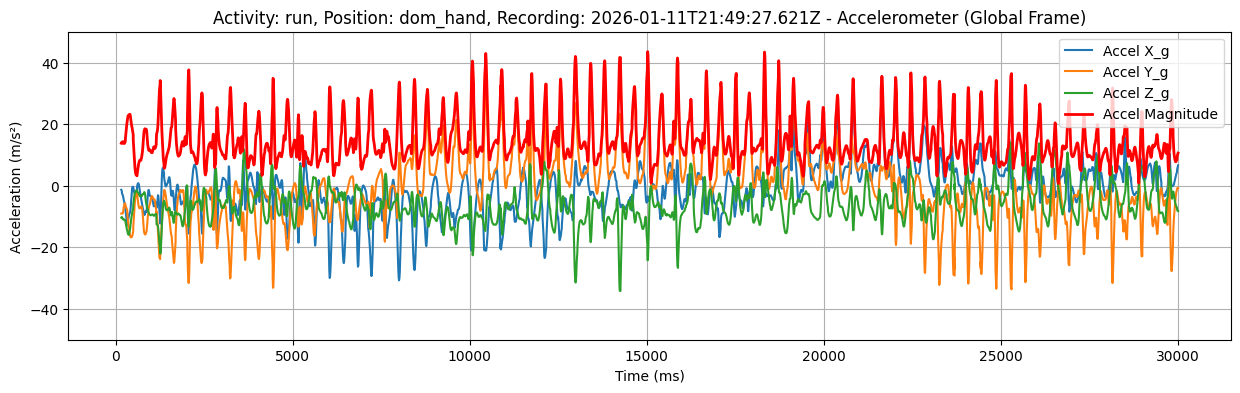

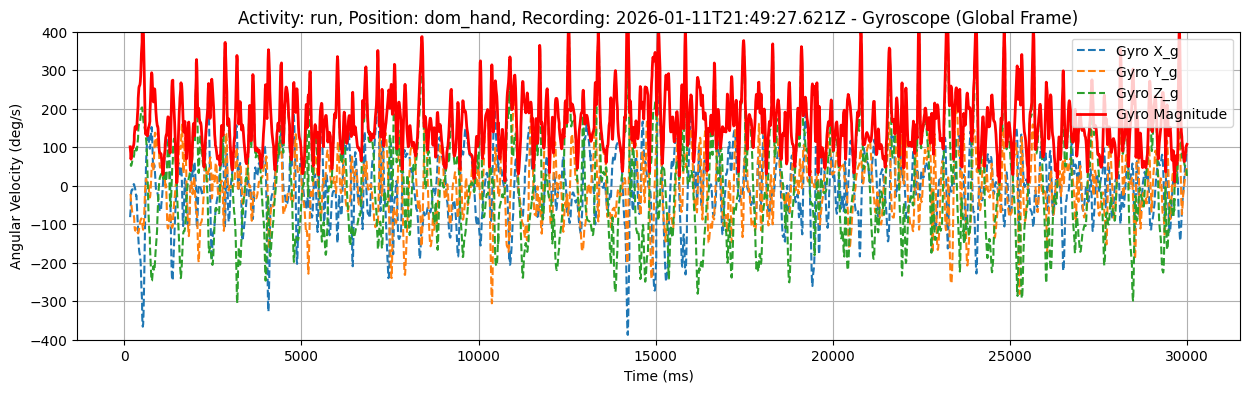

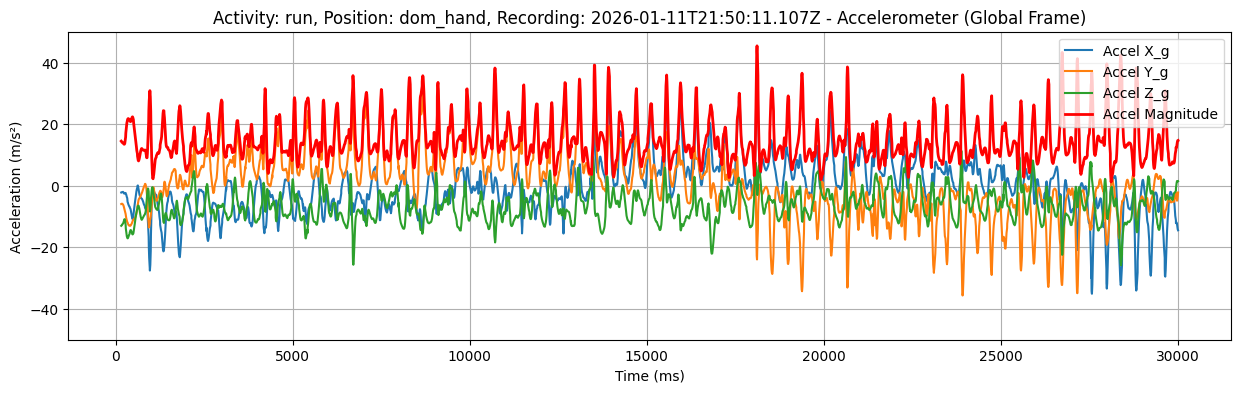

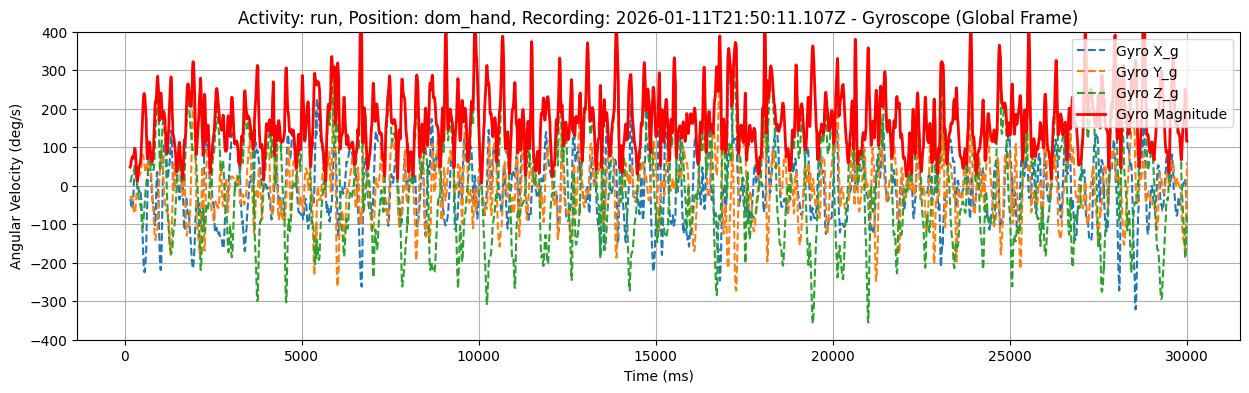

In [62]:
def visualize_global_frame_recordings(recordings):
    for df in recordings:
        title = f"Activity: {df['activity'].iloc[0]}, Position: {df['phone_position'].iloc[0]}, Recording: {df['recording_id'].iloc[0]}"

        accel_mag = np.sqrt(df['ax_g']**2 + df['ay_g']**2 + df['az_g']**2)
        plt.figure(figsize=(15, 4))
        plt.title(f"{title} - Accelerometer (Global Frame)")
        plt.plot(df['time'], df['ax_g'], label='Accel X_g')
        plt.plot(df['time'], df['ay_g'], label='Accel Y_g')
        plt.plot(df['time'], df['az_g'], label='Accel Z_g')
        plt.plot(df['time'], accel_mag, label='Accel Magnitude', color='r', linewidth=2)
        plt.xlabel("Time (ms)")
        plt.ylabel("Acceleration (m/s²)")
        plt.ylim(-50, 50) 
        plt.legend(loc='upper right')
        plt.grid(True)
        plt.show()

        gyro_mag = np.sqrt(df['gx_g']**2 + df['gy_g']**2 + df['gz_g']**2)
        plt.figure(figsize=(15, 4))
        plt.title(f"{title} - Gyroscope (Global Frame)")
        plt.plot(df['time'], df['gx_g'], '--', label='Gyro X_g')
        plt.plot(df['time'], df['gy_g'], '--', label='Gyro Y_g')
        plt.plot(df['time'], df['gz_g'], '--', label='Gyro Z_g')
        plt.plot(df['time'], gyro_mag, label='Gyro Magnitude', color='r', linewidth=2)
        plt.xlabel("Time (ms)")
        plt.ylabel("Angular Velocity (deg/s)")
        plt.ylim(-400, 400) 
        plt.legend(loc='upper right')
        plt.grid(True)
        plt.show()
visualize_global_frame_recordings(gft_data)